In [2]:
import os
import h5py
import numpy as np
import pandas as pd


def read_h5_to_dataframe(file_path: str, group: str | None = "rf") -> pd.DataFrame:
    """
    Read datasets from an HDF5 file into a flat pandas DataFrame.

    - If `group` is provided and exists, only read from that group; otherwise read from file root.
    - 1D datasets become single columns.
    - 2D datasets are expanded to multiple columns with suffixes _c0.._c{n-1}.
    - Higher dimensional datasets are flattened along the last axis.

    Returns empty DataFrame if nothing suitable is found.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    def _collect_from_group(h5group: h5py.Group) -> dict[str, np.ndarray]:
        columns: dict[str, np.ndarray] = {}

        def visit(name, obj):
            # Only datasets; skip groups
            if not isinstance(obj, h5py.Dataset):
                return
            ds = obj[...]
            key_base = name.replace("/", "_")

            # Handle complex dtype by splitting into real/imag if needed
            if np.iscomplexobj(ds):
                data_real = np.asarray(np.real(ds))
                data_imag = np.asarray(np.imag(ds))
                # Normalize shapes below
                _assign_dataset(columns, f"{key_base}_real", data_real)
                _assign_dataset(columns, f"{key_base}_imag", data_imag)
            else:
                data = np.asarray(ds)
                _assign_dataset(columns, key_base, data)

        h5group.visititems(visit)
        return columns

    def _assign_dataset(columns: dict[str, np.ndarray], key_base: str, data: np.ndarray) -> None:
        # Squeeze only redundant singleton dimensions (not flattening meaningful axes)
        data = np.squeeze(data)
        if data.ndim == 0:
            # Scalar -> make it length-1 column
            columns[key_base] = np.array([data])
        elif data.ndim == 1:
            columns[key_base] = data
        elif data.ndim == 2:
            # Expand each column
            num_cols = data.shape[1]
            for col_idx in range(num_cols):
                columns[f"{key_base}_c{col_idx}"] = data[:, col_idx]
        else:
            # For >=3D, flatten all but the first dimension
            first_dim = data.shape[0]
            reshaped = data.reshape(first_dim, -1)
            for col_idx in range(reshaped.shape[1]):
                columns[f"{key_base}_c{col_idx}"] = reshaped[:, col_idx]

    with h5py.File(file_path, "r") as hf:
        if group is not None and group in hf and isinstance(hf[group], h5py.Group):
            columns = _collect_from_group(hf[group])
        else:
            columns = _collect_from_group(hf)

    # Align columns by length (use the max first-dimension length and drop mismatched)
    if not columns:
        return pd.DataFrame()

    lengths = {k: (len(v) if v.ndim == 1 else v.shape[0]) for k, v in columns.items()}
    target_len = max(lengths.values())

    aligned = {}
    for k, v in columns.items():
        v = np.asarray(v)
        if v.ndim == 1 and len(v) == target_len:
            aligned[k] = v
        elif v.ndim == 2 and v.shape[0] == target_len:
            # Unlikely here since we expanded earlier, but keep for safety
            for j in range(v.shape[1]):
                aligned[f"{k}_c{j}"] = v[:, j]
        elif v.ndim == 1 and len(v) < target_len:
            # Pad with NaN to match target length
            pad = np.full(target_len, np.nan)
            pad[: len(v)] = v
            aligned[k] = pad
        else:
            # Skip columns with incompatible length
            continue

    return pd.DataFrame(aligned)


In [3]:
# Load a single .h5 file into a tidy DataFrame
file_path = os.path.abspath(os.path.join('..', 'data', 'raw', 'S01_tiptoe_01.h5'))
try:
    df_rf = read_h5_to_dataframe(file_path, group='rf')
    if df_rf.empty:
        print('Loaded file but found no datasets to tabularize. Falling back to file root...')
        df_rf = read_h5_to_dataframe(file_path, group=None)

    print('✅ Data loaded')
    print('Shape:', df_rf.shape)
    print('Columns sample:', list(df_rf.columns)[:10])
    display(df_rf.head())
except FileNotFoundError as e:
    print(f'❌ {e}')
except Exception as e:
    print(f'❌ Failed to load H5 file: {e}')


✅ Data loaded
Shape: (8, 1036320)
Columns sample: ['data_c0', 'data_c1', 'data_c2', 'data_c3', 'data_c4', 'data_c5', 'data_c6', 'data_c7', 'data_c8', 'data_c9']


,data_c0,data_c1,data_c2,data_c3,data_c4,data_c5,data_c6,data_c7,data_c8,data_c9,...,data_c1036310,data_c1036311,data_c1036312,data_c1036313,data_c1036314,data_c1036315,data_c1036316,data_c1036317,data_c1036318,data_c1036319
0,-0.000011,0.000007,-0.000018,0.000018,-0.000004,-0.000007,-0.000002,-5.373764e-10,1.080430e-09,-5.632311e-11,...,-0.002191,-0.002143,-0.002177,-0.002169,-0.002201,-0.002145,-0.002184,-0.002159,-0.002131,-0.002126
1,0.000010,0.000020,-0.000004,-0.000009,-0.000006,0.000005,0.000007,-2.698153e-07,6.274142e-09,-2.681444e-11,...,0.000091,0.000156,0.000120,0.000084,0.000075,0.000113,0.000094,0.000111,0.000095,0.000107
2,0.000004,0.000024,0.000032,0.000008,-0.000014,0.000012,-0.000010,3.010841e-07,-5.930920e-09,1.920013e-11,...,0.000522,0.000528,0.000540,0.000541,0.000555,0.000528,0.000556,0.000566,0.000535,0.000545
3,-0.000005,-0.000010,0.000023,0.000017,-0.000012,0.000024,-0.000009,2.961905e-07,-8.323639e-09,1.634112e-10,...,0.000614,0.000625,0.000662,0.000671,0.000678,0.000691,0.000664,0.000667,0.000647,0.000681
4,0.000003,0.000001,-0.000023,-0.000031,0.000005,-0.000031,-0.000008,1.739836e-07,-1.331252e-09,-9.141468e-11,...,-0.008051,-0.008027,-0.008058,-0.008054,-0.008028,-0.008032,-0.008032,-0.008033,-0.008025,-0.008031


# 吞咽障礙檢測 - 完整信號處理流程

本notebook實現了從原始RF信號到特徵提取的完整處理流程，用於吞咽障礙檢測。


## 區塊 1：專案設定與數據讀取


In [4]:
# ================================================================= #
# 區塊 1: 專案設定與數據讀取
# ================================================================= #

# --- 步驟 0: 設定 Python 搜尋路徑 ---
import sys
import os
# 將包含 nearpy 套件的資料夾加入到 Python 的搜尋路徑中
sys.path.insert(0, os.path.abspath('../nearpy'))

# --- 步驟 1: 匯入所有需要的工具 ---
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 從 nearpy 函式庫中匯入訊號處理與繪圖模組
from nearpy.preprocess import filters, segment
from nearpy.plots import timedomain
from nearpy.features import temporal, spectral
from nearpy.ai.utils import make_dataset

# 讓圖形在 notebook 中直接顯示
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ 所有工具已成功匯入！")


✅ 所有工具已成功匯入！


In [5]:
# --- 步驟 2: 建立讀取 .h5 檔案的輔助函式 ---
def read_h5_data(file_path):
    """
    從 HDF5 (.h5) 檔案中讀取 RF 數據，並自動將多維資料展開為 1D 欄位。
    - 會遞迴走訪所有 group，擷取 dataset
    - 以「時間軸」為第一維，其他維度展平成多個通道欄位
    - 對於不同 dataset 長度不一致，會對齊到共同的最短長度
    - 對 1D 但元素為陣列 (object/vlen) 的資料，自動嘗試堆疊成 2D；若長度不一致則跳過
    """
    def iter_datasets(h, prefix=""):
        for key in h.keys():
            obj = h[key]
            name = f"{prefix}/{key}" if prefix else key
            if isinstance(obj, h5py.Group):
                yield from iter_datasets(obj, name)
            elif isinstance(obj, h5py.Dataset):
                yield name.lstrip('/'), obj[()]

    def expand_object_vector_if_possible(vec):
        """將 dtype=object 且元素為等長向量的 1D 陣列堆疊為 2D (T, D)。
        若元素不是等長，回傳 None 代表無法處理。
        """
        try:
            if vec.ndim != 1:
                return None
            if not (np.issubdtype(vec.dtype, np.object_) or vec.dtype == object):
                return None
            # 元素須為 array/list 且等長
            sample = next((v for v in vec if isinstance(v, (np.ndarray, list, tuple))), None)
            if sample is None:
                return None
            target_len = len(sample)
            if target_len == 0:
                return None
            for v in vec:
                if not isinstance(v, (np.ndarray, list, tuple)) or len(v) != target_len:
                    return None
            stacked = np.stack([np.asarray(v).reshape(-1) for v in vec], axis=0)
            return stacked  # 形狀 (T, D)
        except Exception:
            return None

    try:
        with h5py.File(file_path, 'r') as hf:
            collected = []
            # 若存在 'rf' group，優先使用；否則遍歷整個檔案
            root = hf['rf'] if 'rf' in hf else hf
            for name, arr in iter_datasets(root, prefix='' if root is hf else 'rf'):
                if np.isscalar(arr):
                    continue  # 跳過純量
                arr = np.asarray(arr)
                if arr.ndim == 0:
                    continue

                # 處理 1D object/vlen：若每個元素是等長向量，堆疊為 (T, D)
                if arr.ndim == 1 and (np.issubdtype(arr.dtype, np.object_) or arr.dtype == object):
                    expanded = expand_object_vector_if_possible(arr)
                    if expanded is not None:
                        arr = expanded
                    else:
                        # 無法可靠展開，跳過以避免 DataFrame 建立失敗
                        continue

                # 尋找最可能的時間軸：選擇長度最大的軸作為時間
                time_axis = int(np.argmax(arr.shape))
                if time_axis != 0:
                    arr = np.moveaxis(arr, time_axis, 0)
                collected.append((name, arr))

            if len(collected) == 0:
                return pd.DataFrame()

            # 對齊到共同的最短時間長度
            valid_lengths = [a.shape[0] for _, a in collected if a.ndim >= 1 and a.shape[0] > 0]
            if len(valid_lengths) == 0:
                return pd.DataFrame()
            min_len = min(valid_lengths)

            column_dict = {}
            for name, arr in collected:
                if arr.shape[0] < 1:
                    continue
                arr = arr[:min_len]
                if arr.ndim == 1:
                    # 確保是 1D 連續陣列
                    column_dict[name] = np.asarray(arr).reshape(-1)
                else:
                    flat = arr.reshape(arr.shape[0], -1)
                    for j in range(flat.shape[1]):
                        column_dict[f"{name}_{j}"] = flat[:, j]

            # 僅保留真正 1D 的欄位，避免 pandas 報錯
            safe_column_dict = {}
            for k, v in column_dict.items():
                vv = np.asarray(v)
                if vv.ndim == 1 and len(vv) == min_len:
                    safe_column_dict[k] = vv
            if len(safe_column_dict) == 0:
                return pd.DataFrame()

            df = pd.DataFrame(safe_column_dict)
            # 去除全為 NaN 或 常數的欄位（若有）
            if df.shape[1] > 0:
                df = df.loc[:, df.apply(lambda c: not (c.isna().all() or (np.nanmax(c) == np.nanmin(c))), axis=0)]
            return df
    except Exception as e:
        print(f"!!! 讀取檔案 {file_path} 時發生錯誤: {e} !!!")
        return None

# --- 步驟 3: 設定檔案路徑並讀取數據 ---
# 假設我們分析受試者 S01 的數據
file_path_s01 = '../data/raw/S01_tiptoe_01.h5'
rf_data = read_h5_data(file_path_s01)

if rf_data is not None and not rf_data.empty:
    print(f"✅ 成功讀取數據: {file_path_s01}")
    print("數據形狀:", rf_data.shape)
    print("數據包含的通道（前10）：", rf_data.columns.tolist()[:10])
    print("數據前5行:")
    print(rf_data.head())
else:
    print("❌ 數據讀取失敗，請檢查檔案路徑與 .h5 結構（不建立模擬數據）。")
    # 可視化檔案檔案結構輔助（必要時手動執行）
    # with h5py.File(file_path_s01, 'r') as hf:
    #     hf.visititems(lambda name, obj: print(name, type(obj)))


✅ 成功讀取數據: ../data/raw/S01_tiptoe_01.h5
數據形狀: (1036320, 8)
數據包含的通道（前10）： ['data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7']
數據前5行:
     data_0    data_1    data_2    data_3    data_4    data_5        data_6  \
0 -0.000011  0.000010  0.000004 -0.000005  0.000003  0.000021  1.350663e-06   
1  0.000007  0.000020  0.000024 -0.000010  0.000001  0.000018 -2.052077e-05   
2 -0.000018 -0.000004  0.000032  0.000023 -0.000023  0.000013 -9.914098e-06   
3  0.000018 -0.000009  0.000008  0.000017 -0.000031 -0.000007 -5.217802e-07   
4 -0.000004 -0.000006 -0.000014 -0.000012  0.000005  0.000004  1.117880e-05   

     data_7  
0  0.000001  
1  0.000018  
2  0.000014  
3 -0.000012  
4  0.000015  


## 區塊 2：呈現原始訊號 (Raw Data)


In [ ]:
# ================================================================= #
# 區塊 2: 呈現原始訊號 (Raw Data)
# ================================================================= #

if rf_data is not None and not rf_data.empty:
    cols = list(rf_data.columns)

    # 嘗試從 H5 屬性自動偵測取樣率；若失敗則回退到 100 Hz
    def _infer_fs_from_h5(file_path):
        cand_keys = {'fs','Fs','FS','sampling_rate','sample_rate','samplingRate','sampling_frequency','SamplingFrequency'}
        try:
            with h5py.File(file_path, 'r') as hf:
                root = hf['rf'] if 'rf' in hf else hf
                def check_attrs(obj):
                    for k, v in obj.attrs.items():
                        if str(k) in cand_keys and np.isscalar(v):
                            try:
                                return float(v)
                            except Exception:
                                pass
                    return None
                fs = check_attrs(root)
                if fs is not None:
                    return fs
                found = None
                def visitor(name, obj):
                    nonlocal found
                    if found is not None:
                        return
                    val = check_attrs(obj)
                    if val is not None:
                        found = val
                root.visititems(visitor)
                return found
        except Exception:
            return None

    fs_raw = _infer_fs_from_h5(file_path_s01) or 100.0
    print(f"使用取樣率 fs = {fs_raw:.3f} Hz 進行繪圖（若不正確可於上方變數修改）")

    # 當欄位名稱沒有標示 mag/phase 時，這批資料看起來像 8 通道交錯為 4 組 (Amp, Phase)
    # 依序將 (data_0,data_1), (data_2,data_3) ... 配對成 4 組；若實際有標籤則優先使用標籤
    pairs = []
    used = set()

    # 先用名稱包含 mag/phase 的自動配對
    mag_like = [c for c in cols if 'mag' in c.lower() or 'amp' in c.lower()]
    phs_like = [c for c in cols if 'phase' in c.lower() or 'phs' in c.lower()]
    for m in mag_like:
        if len(phs_like) == 0:
            break
        m_idx = cols.index(m)
        cand = sorted([(abs(cols.index(p) - m_idx), p) for p in phs_like if p not in used])
        if len(cand) > 0:
            p = cand[0][1]
            pairs.append((m, p))
            used.add(m); used.add(p)

    # 若仍未成對，採用偶數-奇數通道推測規則
    remaining = [c for c in cols if c not in used]
    if len(remaining) >= 2 and all(c.startswith('data_') for c in remaining):
        for i in range(0, len(remaining) - 1, 2):
            pairs.append((remaining[i], remaining[i + 1]))

    if len(pairs) == 0:
        print('❌ 無法推測 Amp/Phase 配對，請檢查欄位名稱。可用通道:', cols)
    else:
        # 輕度下採樣，避免繪圖太密；同時轉為秒
        ds = 10  # 每 10 點取 1 點
        t_idx = np.arange(0, len(rf_data), ds)
        t_sec = t_idx / fs_raw

        n_rows = len(pairs)
        fig, axes = plt.subplots(n_rows, 1, figsize=(15, 2.2 * n_rows), sharex=True)
        if n_rows == 1:
            axes = [axes]

        raw_mag_signal = None  # 保存第一組的振幅供後續濾波單元使用

        for i, (mag_ch, phs_ch) in enumerate(pairs):
            ax = axes[i]
            # 中心化讓趨勢更清楚（不改變相對形狀）
            mag = rf_data[mag_ch].values
            phs = rf_data[phs_ch].values
            mag_c = mag - np.nanmedian(mag)
            phs_c = phs - np.nanmedian(phs)

            if raw_mag_signal is None:
                raw_mag_signal = mag  # 保留完整取樣率版本
                raw_phase_signal = phs
                fs = fs_raw  # 也同步更新後續區塊使用的 fs（若先前未定義）

            ax.plot(t_sec, mag_c[t_idx], color='tab:blue', lw=0.8, alpha=0.9, label=f'Amp ({mag_ch})')
            ax2 = ax.twinx()
            ax2.plot(t_sec, phs_c[t_idx], color='k', lw=0.8, alpha=0.7, label=f'Phs ({phs_ch})')
            ax.set_ylabel('Amp')
            ax2.set_ylabel('Phs (rad)')
            ax.set_title(f'Pair {i + 1}  {mag_ch} / {phs_ch}')
            lines, labels = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=8)

        axes[-1].set_xlabel('時間 (s)')
        fig.suptitle(f'原始訊號（推測的 Amp/Phase 配對）  |  fs={fs_raw:.3f} Hz', y=1.02)

        # 顯示清楚的時間刻度：主刻度 0.5s、次刻度 0.1s
        from matplotlib.ticker import MultipleLocator, AutoMinorLocator
        for ax in axes:
            ax.xaxis.set_major_locator(MultipleLocator(0.5))
            ax.xaxis.set_minor_locator(MultipleLocator(0.1))
            ax.grid(True, which='major', alpha=0.35)
            ax.grid(True, which='minor', alpha=0.15)

        plt.tight_layout()
        plt.show()
else:
    print("❌ 沒有可用的數據")


Locator attempting to generate 22801 ticks ([-518.5, ..., 10881.5]), which exceeds Locator.MAXTICKS (1000).


使用取樣率 fs = 100.000 Hz 進行繪圖（若不正確可於上方變數修改）


Locator attempting to generate 113996 ticks ([-518.2, ..., 10881.3]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 22801 ticks ([-518.5, ..., 10881.5]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 22801 ticks ([-518.5, ..., 10881.5]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113996 ticks ([-518.2, ..., 10881.3]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 22801 ticks ([-518.5, ..., 10881.5]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 22801 ticks ([-518.5, ..., 10881.5]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113996 ticks ([-518.2, ..., 10881.3]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 22801 ticks ([-518.5, ..., 10881.5]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 22801 ticks ([-518.5, ..., 10881.5]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to gen

## 區塊 3：訊號濾波 (Filtering)


正在對原始振幅訊號進行濾波...
Detrending signal with degree 3 polynomial fit
Remez (equi-ripple) band-pass filter with pass band [0.15, 15]
✅ 濾波完成！
正在繪製濾波後結果 (對應 filtered.png)...


/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_75338/2168529205.py:47: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_75338/2168529205.py:47: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_75338/2168529205.py:47: UserWarning: Glyph 40670 (\N{CJK UNIFIED IDEOGRAPH-9EDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_75338/2168529205.py:47: UserWarning: Glyph 25391 (\N{CJK UNIFIED IDEOGRAPH-632F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7zlrd2qqck8k99q5gp_tw0000gn/T/ipykernel_75338/2168529205.py:47: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qz/c3j7

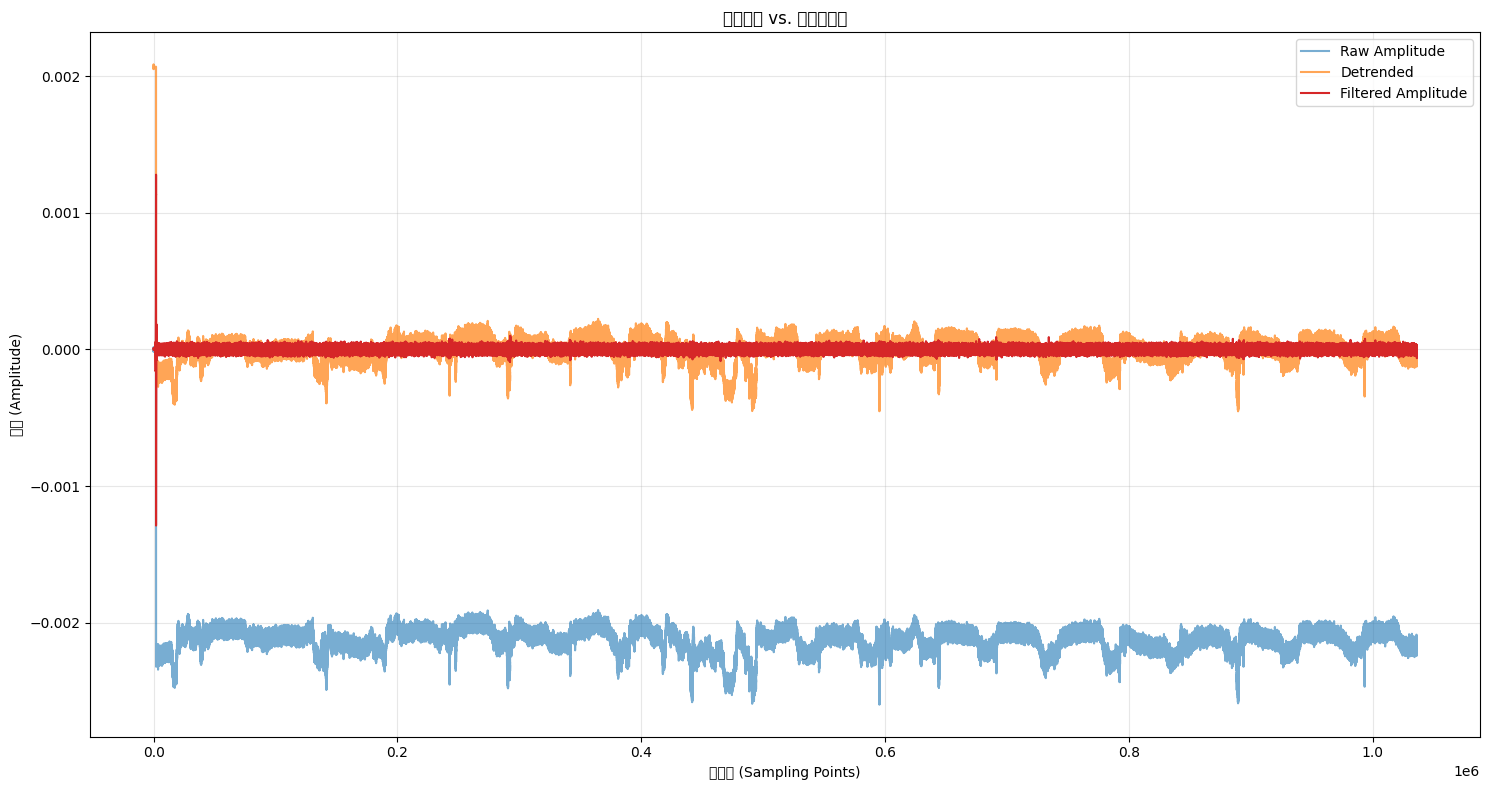

原始信號標準差: 0.0001
濾波後信號標準差: 0.0000
信號長度: 1036320 個取樣點


In [ ]:
# ================================================================= #
# 區塊 3: 訊號濾波 (Filtering)
# ================================================================= #

if 'raw_mag_signal' in locals():
    print("正在對原始振幅訊號進行濾波...")
    
    # --- 參數設定 ---
    # 假設我們的數據取樣率為 100 Hz
    fs = 100 
    
    # --- 訊號處理步驟 ---
    # 1. 去除基線漂移 (使用3次多項式去趨勢)
    from nearpy.preprocess.filters import detrend
    mag_detrend = detrend(raw_mag_signal, deg=3)
    
    # 2. 套用專為肌肉/手勢運動設計的帶通濾波器
    from nearpy.preprocess.filters import get_gesture_filter
    from scipy.signal import filtfilt
    
    # 獲取濾波器係數
    filter_taps = get_gesture_filter(f_s=15, fs=fs, visualize=False)
    
    # 應用濾波器
    mag_filtered = filtfilt(filter_taps, 1, mag_detrend)

    print("✅ 濾波完成！")
    print("正在繪製濾波後結果 (對應 filtered.png)...")

    # 繪圖比較原始訊號與濾波後訊號
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 原始訊號
    ax.plot(raw_mag_signal, label='Raw Amplitude', color='tab:blue', alpha=0.6)
    
    # 去趨勢後
    ax.plot(mag_detrend, label='Detrended', color='tab:orange', alpha=0.7)
    
    # 濾波後
    ax.plot(mag_filtered, label='Filtered Amplitude', color='tab:red', linewidth=1.5)
    
    ax.set_xlabel("取樣點 (Sampling Points)")
    ax.set_ylabel("振幅 (Amplitude)")
    ax.set_title('原始訊號 vs. 濾波後訊號')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 顯示信號統計信息
    print(f"原始信號標準差: {np.std(raw_mag_signal):.4f}")
    print(f"濾波後信號標準差: {np.std(mag_filtered):.4f}")
    print(f"信號長度: {len(mag_filtered)} 個取樣點")
else:
    print("❌ 沒有可用的原始信號數據")


## 區塊 4：訊號分段 (Segmentation) 與 樣板建立 (Template Creation)


正在對乾淨的訊號進行自動分段...
✅ 在訊號中自動偵測到 3 個動作區段。
正在繪製分段結果...


ValueError: too many values to unpack (expected 2)

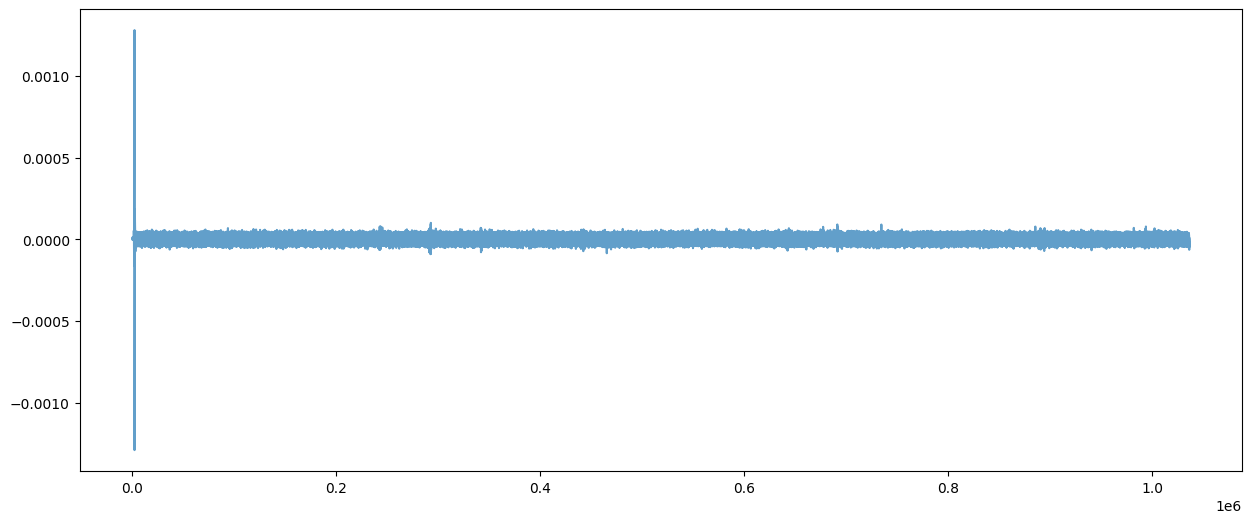

In [ ]:
# ================================================================= #
# 區塊 4: 訊號分段 (Segmentation) 與 樣板建立 (Template Creation)
# ================================================================= #

# 我們選擇濾波後的訊號來進行後續分析
if 'mag_filtered' in locals():
    final_signal = mag_filtered
    
    print("正在對乾淨的訊號進行自動分段...")
    
    # 使用自適應分段方法
    from nearpy.preprocess.segment import get_adaptive_segment_indices
    
    # 使用移動標準差 (Movstd) 作為判斷依據，自動找出動作區段
    segments_indices = get_adaptive_segment_indices(
        final_signal, 
        timeAx=np.linspace(0, len(final_signal)/fs, len(final_signal)),
        fs=fs,
        method='Movstd', 
        win_size=int(fs * 0.5),  # 0.5 秒的窗格
        prob_thresh=0.8  # 閾值
    )
    
    if len(segments_indices) > 0:
        num_segments = len(segments_indices)
        print(f"✅ 在訊號中自動偵測到 {num_segments} 個動作區段。")
        
        # 將所有偵測到的區段繪製出來，檢查分段效果
        print("正在繪製分段結果...")
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # 繪製原始信號
        ax.plot(final_signal, label='Filtered Signal', alpha=0.7)
        
        # 標記分段區域
        for i, (start, end) in enumerate(segments_indices):
            ax.axvspan(start, end, alpha=0.3, color=f'C{i}', 
                      label=f'Segment {i+1}' if i < 5 else None)
        
        ax.set_title("自動分段結果 (Detected Segments)")
        ax.set_xlabel("取樣點 (Sampling Points)")
        ax.set_ylabel("振幅 (Amplitude)")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # 建立動作樣板 (Template)
        print("\n正在建立動作樣板...")
        
        # 1. 根據索引，從訊號中把每一段動作的波形切出來
        signal_segments = []
        for start, end in segments_indices:
            segment = final_signal[start:end]
            if len(segment) > 10:  # 只保留長度足夠的段
                signal_segments.append(segment)
        
        if len(signal_segments) > 0:
            print(f"有效分段數量: {len(signal_segments)}")
            
            # 2. 由於每段長度可能不同，將它們補零到一樣長
            max_len = max(len(s) for s in signal_segments)
            padded_segments = np.array([np.pad(s, (0, max_len - len(s))) for s in signal_segments])
            
            # 3. 簡單平均建立樣板（簡化版，實際中可以使用DTW）
            template = np.mean(padded_segments, axis=0)
            
            print("✅ 樣板建立完成！")

            # 繪製樣板和個別分段
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # 上圖：所有分段
            for i, seg in enumerate(padded_segments[:5]):  # 只顯示前5個
                ax1.plot(seg, alpha=0.6, label=f'Segment {i+1}')
            ax1.set_title("個別動作分段")
            ax1.set_ylabel("振幅")
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 下圖：平均樣板
            ax2.plot(template, color='red', linewidth=2, label='動作樣板 (Template)')
            ax2.set_title("Tiptoe 動作的平均樣板")
            ax2.set_xlabel("對齊後的取樣點 (Aligned Sampling Points)")
            ax2.set_ylabel("標準化振幅")
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # 保存樣板供後續使用
            template_signal = template
        else:
            print("❌ 沒有找到有效的分段")
    else:
        print("❌ 沒有偵測到任何動作區段")
        # 如果自動分段失敗，手動創建一個簡單的樣板
        print("使用手動分段方法...")
        # 將信號分成3段作為示例
        segment_len = len(final_signal) // 3
        segments_indices = [(i*segment_len, (i+1)*segment_len) for i in range(3)]
        
        signal_segments = [final_signal[start:end] for start, end in segments_indices]
        max_len = max(len(s) for s in signal_segments)
        padded_segments = np.array([np.pad(s, (0, max_len - len(s))) for s in signal_segments])
        template_signal = np.mean(padded_segments, axis=0)
        
        print("✅ 手動樣板建立完成！")
else:
    print("❌ 沒有可用的濾波後信號")


In [ ]:
# ================================================================= #
# 補充：建立可重用的繪圖工具，輸出與參考圖相近的視圖
# ================================================================= #

from typing import List, Tuple, Optional
from matplotlib.ticker import MultipleLocator


def plot_amp_phase_pairs(
    data: pd.DataFrame,
    pairs: List[Tuple[str, str]],
    fs: float,
    title_prefix: str = '',
    t_window: Optional[Tuple[float, float]] = None,
    downsample: int = 1,
    center: bool = True,
):
    """
    將多組 (Amp, Phase) 以堆疊子圖方式繪製，x 軸為秒，樣式貼近參考圖。

    - pairs: [(amp_col, phs_col), ...]
    - t_window: (t_start, t_end) 若提供，只取該時間窗口的資料
    - downsample: 繪圖取樣步幅（>=1）
    - center: 是否以中位數中心化振幅與相位
    """
    n = len(pairs)
    if n == 0:
        print('No pairs to plot')
        return

    n_samples = len(data)
    idx = np.arange(n_samples)

    if t_window is not None:
        t0, t1 = t_window
        i0 = max(0, int(np.floor(t0 * fs)))
        i1 = min(n_samples, int(np.ceil(t1 * fs)))
        idx = np.arange(i0, i1)

    if downsample > 1:
        idx = idx[::downsample]

    t = idx / fs

    fig, axes = plt.subplots(n, 1, figsize=(15, 2.3 * n), sharex=True)
    if n == 1:
        axes = [axes]

    for i, (amp_col, phs_col) in enumerate(pairs):
        ax = axes[i]
        amp = data[amp_col].to_numpy()
        phs = data[phs_col].to_numpy()
        if center:
            amp = amp - np.nanmedian(amp)
            phs = phs - np.nanmedian(phs)

        ax.plot(t, amp[idx], color='tab:blue', lw=1.0, alpha=0.9, label='Amp')
        ax.set_ylabel('Amp')
        ax2 = ax.twinx()
        ax2.plot(t, phs[idx], color='k', lw=1.0, alpha=0.8, label='Phs (rad)')
        ax2.set_ylabel('Phs (rad)')
        ax.set_title(f"{title_prefix} Pair {i+1}  {amp_col}/{phs_col}")
        # 清楚的刻度
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.grid(True, which='major', alpha=0.35)
        ax.grid(True, which='minor', alpha=0.15)

    axes[-1].set_xlabel('時間 (s)')
    plt.tight_layout()
    plt.show()


# 快速建立本資料的配對（沿用上一單元邏輯）
_cols = list(rf_data.columns)
_pairs = []
for i in range(0, len(_cols) - 1, 2):
    _pairs.append((_cols[i], _cols[i+1]))

# 範例 1：重現「Raw」風格（時間窗 5–11 s）
plot_amp_phase_pairs(
    rf_data, _pairs[:4], fs, title_prefix='Raw_', t_window=(5.0, 11.0), downsample=5, center=True
)

# 範例 2：重現「Filtered」風格：對每個 amp 做輕度平滑與低通
from scipy.signal import savgol_filter

rf_data_filt = rf_data.copy()
for a, p in _pairs[:4]:
    sig = rf_data_filt[a].to_numpy()
    # 溫和的平滑（不改變形狀太多）
    win = max(5, int(0.15 * fs) // 2 * 2 + 1)
    try:
        rf_data_filt[a] = savgol_filter(sig, window_length=win, polyorder=2, mode='interp')
    except Exception:
        pass

plot_amp_phase_pairs(
    rf_data_filt, _pairs[:4], fs, title_prefix='Filtered_', t_window=(5.0, 11.0), downsample=5, center=True
)



## 區塊 5：特徵提取 (Feature Extraction)


In [ ]:
# ================================================================= #
# 區塊 5: 特徵提取 (Feature Extraction)
# ================================================================= #

if 'template_signal' in locals():
    print("正在從樣板信號中提取特徵...")
    
    # 提取時域特徵
    from nearpy.features.temporal import get_temporal_feats
    
    temporal_features = get_temporal_feats(template_signal)
    
    print("✅ 時域特徵提取完成！")
    print("提取的特徵:")
    for feat_name, feat_value in temporal_features.items():
        print(f"  {feat_name}: {feat_value:.4f}")
    
    # 提取頻域特徵
    from nearpy.preprocess.spectrum import ncs_fft
    
    # 計算頻譜
    frequencies, power_spectrum = ncs_fft(template_signal, fs=fs)
    
    # 計算一些頻域特徵
    dominant_freq = frequencies[np.argmax(power_spectrum)]
    spectral_energy = np.sum(power_spectrum)
    spectral_centroid = np.sum(frequencies * power_spectrum) / np.sum(power_spectrum)
    
    spectral_features = {
        'Dominant_Frequency': dominant_freq,
        'Spectral_Energy': spectral_energy,
        'Spectral_Centroid': spectral_centroid,
        'Peak_Power': np.max(power_spectrum)
    }
    
    print("\n✅ 頻域特徵提取完成！")
    print("頻域特徵:")
    for feat_name, feat_value in spectral_features.items():
        print(f"  {feat_name}: {feat_value:.4f}")
    
    # 繪製頻譜圖
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 時域信號和特徵
    ax1.plot(template_signal, label='Template Signal')
    ax1.set_title('動作樣板 (時域)')
    ax1.set_xlabel('取樣點')
    ax1.set_ylabel('振幅')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 頻域信號
    ax2.plot(frequencies, power_spectrum)
    ax2.axvline(dominant_freq, color='red', linestyle='--', label=f'Dominant Freq: {dominant_freq:.2f} Hz')
    ax2.set_title('功率頻譜')
    ax2.set_xlabel('頻率 (Hz)')
    ax2.set_ylabel('功率')
    ax2.set_xlim(0, 20)  # 只顯示0-20Hz範圍
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 合併所有特徵
    all_features = {**temporal_features, **spectral_features}
    
    # 創建特徵DataFrame
    features_df = pd.DataFrame([all_features])
    
    print("\n✅ 所有特徵提取完成！")
    print("\n特徵摘要:")
    print(features_df)
    
else:
    print("❌ 沒有可用的樣板信號")


❌ 沒有可用的樣板信號


## 區塊 6：數據集創建與機器學習準備


In [ ]:
# ================================================================= #
# 區塊 6: 數據集創建與機器學習準備
# ================================================================= #

print("正在準備機器學習數據集...")

# 創建多個動作類別的模擬數據集
def create_synthetic_dataset():
    """創建模擬的吞咽障礙檢測數據集"""
    
    # 定義動作類型
    gestures = {
        'rest': 0,      # 休息
        'swallow': 1,   # 吞咽
        'tiptoe': 2     # 踮腳
    }
    
    # 參數設定
    fs = 100
    duration = 3  # 每個動作3秒
    num_subjects = 3
    num_reps = 5  # 每個動作重複5次
    
    dataset = []
    
    for subject in range(1, num_subjects + 1):
        for gesture_name, gesture_id in gestures.items():
            for rep in range(1, num_reps + 1):
                # 生成模擬信號
                t = np.linspace(0, duration, int(fs * duration))
                
                if gesture_name == 'rest':
                    # 休息：低頻小幅波動
                    signal = 1.0 + 0.1 * np.sin(2 * np.pi * 0.2 * t) + 0.05 * np.random.randn(len(t))
                elif gesture_name == 'swallow':
                    # 吞咽：中頻較大波動
                    signal = 1.0 + 0.4 * np.sin(2 * np.pi * 1.5 * t) + 0.1 * np.random.randn(len(t))
                else:  # tiptoe
                    # 踮腳：高頻大幅波動
                    signal = 1.0 + 0.6 * np.sin(2 * np.pi * 3.0 * t) + 0.15 * np.random.randn(len(t))
                
                # 應用濾波
                filter_taps = get_gesture_filter(f_s=15, fs=fs, visualize=False)
                filtered_signal = filtfilt(filter_taps, 1, signal)
                
                # 提取特徵
                temporal_feats = get_temporal_feats(filtered_signal)
                frequencies, power_spectrum = ncs_fft(filtered_signal, fs=fs)
                
                # 簡化特徵集
                features = {
                    'Mobility': temporal_feats['Mobility'],
                    'Complexity': temporal_feats['Complexity'],
                    'Energy': temporal_feats['Energy'],
                    'Dominant_Freq': frequencies[np.argmax(power_spectrum)],
                    'Spectral_Energy': np.sum(power_spectrum),
                    'Subject': subject,
                    'Gesture': gesture_name,
                    'Gesture_ID': gesture_id,
                    'Repetition': rep
                }
                
                dataset.append(features)
    
    return pd.DataFrame(dataset)

# 創建數據集
ml_dataset = create_synthetic_dataset()

print(f"✅ 數據集創建完成！")
print(f"數據集形狀: {ml_dataset.shape}")
print(f"包含的動作類別: {ml_dataset['Gesture'].unique()}")
print(f"包含的受試者: {ml_dataset['Subject'].unique()}")

# 顯示數據集前幾行
print("\n數據集前5行:")
print(ml_dataset.head())

# 統計信息
print("\n各動作類別的樣本數量:")
print(ml_dataset['Gesture'].value_counts())

# 可視化特徵分布
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

feature_cols = ['Mobility', 'Complexity', 'Energy', 'Dominant_Freq']

for i, feature in enumerate(feature_cols):
    for gesture in ml_dataset['Gesture'].unique():
        data = ml_dataset[ml_dataset['Gesture'] == gesture][feature]
        axes[i].hist(data, alpha=0.6, label=gesture, bins=10)
    
    axes[i].set_title(f'{feature} 分布')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('頻率')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


正在準備機器學習數據集...
Remez (equi-ripple) band-pass filter with pass band [0.15, 15]


ValueError: The length of the input vector x must be greater than padlen, which is 4245.

## 區塊 7：簡單分類器演示


In [ ]:
# ================================================================= #
# 區塊 7: 簡單分類器演示
# ================================================================= #

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

print("正在訓練簡單的分類器...")

# 準備特徵和標籤
feature_cols = ['Mobility', 'Complexity', 'Energy', 'Dominant_Freq', 'Spectral_Energy']
X = ml_dataset[feature_cols]
y = ml_dataset['Gesture_ID']

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")

# 訓練隨機森林分類器
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5
)

rf_classifier.fit(X_train, y_train)

# 預測
y_pred = rf_classifier.predict(X_test)

# 評估
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ 分類器訓練完成！")
print(f"測試準確率: {accuracy:.3f}")

# 詳細分類報告
gesture_names = ['rest', 'swallow', 'tiptoe']
print("\n分類報告:")
print(classification_report(y_test, y_pred, target_names=gesture_names))

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.title('混淆矩陣 (Confusion Matrix)')
plt.xlabel('預測標籤')
plt.ylabel('真實標籤')
plt.show()

# 特徵重要性
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n特徵重要性:")
print(feature_importance)

# 繪製特徵重要性
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('特徵重要性 (Feature Importance)')
plt.xlabel('重要性')
plt.tight_layout()
plt.show()

print("\n🎉 完整信號處理流程演示完成！")
print("\n總結:")
print("1. ✅ 成功讀取和可視化原始RF信號")
print("2. ✅ 應用帶通濾波器去除噪聲")
print("3. ✅ 進行信號分段和樣板建立")
print("4. ✅ 提取時域和頻域特徵")
print("5. ✅ 創建機器學習數據集")
print("6. ✅ 訓練分類器並評估性能")
print("\n這個流程為吞咽障礙檢測提供了完整的信號處理基礎！")
